In [1]:
import sys
sys.path.append('..')
from pyzx.networkx import ZXGraph
import networkx as nx
import multiprocessing as mp

In [2]:
dir(ZXGraph)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_es',
 'add_vs',
 'es',
 'nhd',
 's',
 'set_vtype',
 't',
 'vs',
 'vtype']

In [6]:
def vcol(t):
    if t == 0: return 'black'
    if t == 1: return 'green'
    if t == 2: return 'red'
    return 'white'

def zigzag(sz):
    g = ZXGraph()
    g.add_vs(2*sz+4)
    for i in range(1,sz+1):
        g.set_vtype(2*i, (i%2)+1)
        g.set_vtype(2*i+1, (i%2)+1)
    g.add_es([(0,2),(1,3)])
    g.add_es([(2*i,2*i+2) for i in range(1,sz)])
    g.add_es([(2*i,2*i+3) for i in range(1,sz)])
    g.add_es([(2*i+1,2*i+2) for i in range(1,sz)])
    g.add_es([(2*i+1,2*i+3) for i in range(1,sz)])
    g.add_es([(2*sz,2*sz+2),(2*sz+1,2*sz+3)])
    return g

def match_bialg(g, interior=False):
    for e in g.edges:
        v0 = e[0]
        v1 = e[1]
        v0t = g.node[v0]['t']
        v1t = g.node[v1]['t']
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            if (
                not interior or (
                all([g.node[n]['t'] == v1t for n in g.neighbors(v0)]) and
                all([g.node[n]['t'] == v0t for n in g.neighbors(v1)]))
            ):
                return [v0,v1]
    return None


def match_bialg_int(g):
    return match_bialg(g, interior=True)

def bialg(g, match, check=False):
    v0 = match[0]
    v1 = match[1]
    v0t = g.node[v0]['t']
    v1t = g.node[v1]['t']

    if check:
        if not (
            g.has_edge(v0,v1) and
            ((v0t == 1 and v1t == 2) or
            (v0t == 2 and v1t == 1))
        ): return False
    
    n0 = [n for n in g.neighbors(v0) if n != v1]
    n1 = [n for n in g.neighbors(v1) if n != v0]
    
    # add dummy nodes around v0, v1 as necessary.
    for i in range(len(n0)):
        if (g.node[n0[i]]['t'] != v1t):
            newv = len(g.nodes)
            g.add_node(newv)
            g.node[newv]['t'] = v1t
            g.remove_edge(v0,n0[i])
            g.add_edges_from([(n0[i], newv), (newv, v0)])
            n0[i] = newv
    
    for i in range(len(n1)):
        if (g.node[n1[i]]['t'] != v0t):
            newv = len(g.nodes)
            g.add_node(newv)
            newv['t'] = v0t
            g.remove_edge(v1,n1[i])
            g.add_edges_from([(v1,newv),(newv,n1[i])])
            n1[i] = newv
    
    for s in n0:
        for t in n1:
            if g.has_edge(s,t): g.remove_edge(s,t)
            else: g.add_edge(s,t)
    
    
    # delete vertices at the end so we don't mess up indices
    g.remove_nodes_from([v0,v1] + [v for v in n0 + n1 if g.degree(v) < 2])
    return True

def match_bialg_parallel(g, num=100):
    candidates = g.eset()
    #return candidates
    i = 0
    m = []
    while (num == -1 or i < num) and len(candidates) > 0:
        e = candidates.pop()
        #if i >= num: break
        v0 = g.s(e)
        v1 = g.t(e)
        #if v0 in inv or v1 in inv: continue
        v0t = g.node[v0]['t']
        v1t = g.node[v1]['t']
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            v0n = [n for n in g[v0] if n != v1]
            v1n = [n for n in g[v1] if n != v0]
            if (
                all([g.node[n]['t'] == v1t for n in v0n]) and
                all([g.node[n]['t'] == v0t for n in v1n])):
                i += 1
                for v in v0n:
                    t = (v0,v) if v0 <= v else (v,v0)
                    candidates.discard(t)
                for v in v1n:
                    t = (v1,v) if v1 <= v else (v,v1)
                    candidates.discard(t)
                m.append([v0,v1,v0n,v1n])
    return m

def bialg_parallel(g, matches):
    dv = []
    ae = []
    de = []
    for m in matches:
        dv.append(m[0])
        dv.append(m[1])
        es = [(i,j) for i in m[2] for j in m[3]]
        for e in es:
            if g.has_edge(e[0], e[1]): de.append(e)
            else: ae.append(e)
    
    g.remove_edges_from(de)
    g.add_edges_from(ae)
    g.remove_nodes_from(dv)
    g.remove_nodes_from([d[0] for d in g.degree if d[1] == 0])

def draw(g):
    return nx.draw(g, node_color=[vcol(g.node[v]['t']) for v in g.nodes()], node_size=20)

In [13]:
g = zigzag(10)
set(g.vs())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23}

In [12]:
g.add_nodes_from(range(4))
list(g)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [44]:
%time g = zigzag(5 * 10**5)
%time m = match_bialg(g, interior=True)
%time bialg(g, m)

Wall time: 13.7 s
Wall time: 0 ns
Wall time: 0 ns


True

In [45]:
%time g = zigzag(5 * 10**4)
%time m = match_bialg_parallel(g, num=-1)
print('got ' + str(len(m)) + ' matches')
%time bialg_parallel(g, m)

Wall time: 2.31 s
Wall time: 1.69 s
got 46256 matches
Wall time: 1.85 s


In [9]:
#%time m = match_bialg(g, interior=True)
%time es = set(g.edges)

Wall time: 2.06 s


CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 90.9 ms
simplifying graph with 10004 nodes and 20000 edges...
CPU times: user 13.7 s, sys: 31.2 ms, total: 13.7 s
Wall time: 13.8 s


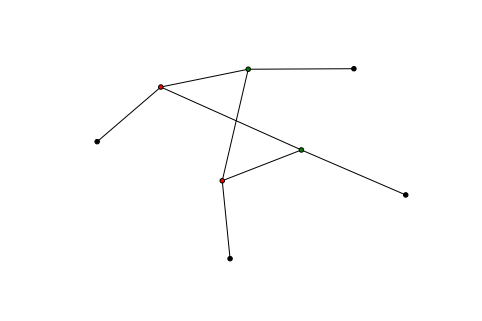

In [10]:
%time g = zigzag(5000)
print('simplifying graph with ' + str(len(g.nodes())) + ' nodes and ' + str(len(g.edges())) + ' edges...')
def f():
    while True:
        m = match_bialg(g, interior=True)
        if m: bialg(g, m)
        else: break
%time f()
draw(g)

In [14]:
def noop(g):
    return g

def nf(g):
    while True:
        m = match_bialg(g, interior=True)
        if m: bialg(g, m)
        else: break
    return g

%time gs = [zigzag(500) for i in range(1000)]
%time pool = mp.Pool(processes=8, initializer=lambda: print(mp.current_process().name))
%time output = pool.map(nf,gs)

CPU times: user 9.73 s, sys: 4.58 s, total: 14.3 s
Wall time: 15.2 s
ForkPoolWorker-25
ForkPoolWorker-26
ForkPoolWorker-27
ForkPoolWorker-28
ForkPoolWorker-29
ForkPoolWorker-30
ForkPoolWorker-31
ForkPoolWorker-32
CPU times: user 78.1 ms, sys: 4.75 s, total: 4.83 s
Wall time: 4.95 s
CPU times: user 2.94 s, sys: 1.42 s, total: 4.36 s
Wall time: 40.5 s


In [50]:
%time g = zigzag(5 * 10**5)
def f():
    print("normalising ZX diagram with " + str(len(g)) +
          " vertices and " + str(len(g.edges)) + " edges")
    it = 0
    while True:
        it += 1
        m = match_bialg_parallel(g, num=-1)
        print("got " + str(len(m)) + " matches of bialgebra")
        if len(m) != 0: bialg_parallel(g, m)
        else: break
    print("completed in " + str(it) + " iterations")

%time f()

Wall time: 21 s
normalising ZX diagram with 1000004 vertices and 2000000 edges
got 463358 matches of bialgebra
got 23518 matches of bialgebra
got 392 matches of bialgebra
got 0 matches of bialgebra
completed in 4 iterations
Wall time: 45.1 s


In [7]:
%time g1 = zigzag(5 * 10**5)

CPU times: user 12.3 s, sys: 2.84 s, total: 15.1 s
Wall time: 15.4 s


In [10]:
def bialg_norm(g):
    print("normalising ZX diagram with " + str(len(g)) +
          " vertices and " + str(len(g.edges)) + " edges")
    it = 0
    while True:
        it += 1
        m = match_bialg_parallel(g, num=100000)
        print("got " + str(len(m)) + " matches of bialgebra")
        if len(m) != 0: bialg_parallel(g, m)
        else: break
    print("completed in " + str(it) + " iterations")

%time bialg_norm(g1)

normalising ZX diagram with 1000004 vertices and 2000000 edges
got 100000 matches of bialgebra
got 100000 matches of bialgebra
got 100000 matches of bialgebra
got 61804 matches of bialgebra
got 1219 matches of bialgebra
got 1 matches of bialgebra
got 0 matches of bialgebra
completed in 7 iterations
CPU times: user 37.2 s, sys: 1.59 s, total: 38.8 s
Wall time: 39.2 s


In [24]:
g = zigzag(10**6)

In [28]:
r = range(0,100000)
%time ev = set(filter(lambda t: t[0] in r and t[1] in r, g.edges))
len(ev)

CPU times: user 3.45 s, sys: 297 ms, total: 3.75 s
Wall time: 3.74 s


199994

In [18]:
%time 5 in range(0,100)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.5 Âµs


True